## Verify GPU

In [ ]:
import tensorflow as tf

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU setup successful") # I'm not sure if this is useful, sometimes it might be
    except RuntimeError as e:
        print(e)

# Verify GPU usage
print("TensorFlow version:", tf.__version__)
print("Is there a GPU:", tf.config.list_physical_devices('GPU'))
print("Current device:", tf.test.gpu_device_name())

## Reading Captchas with OCR Model

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the Dataset

In [ ]:
# Path to the data directory
data_dir = Path("./captcha_images/")

# Get list of all the images
images = sorted(map(str, list(data_dir.glob("*.png"))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
vocab = sorted(set("".join(labels)))
max_length = max(len(label) for label in labels)

# characters = [chr(i) for i in range(65, 91)]  # A-Z
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(vocab))
print("Characters present: ", vocab)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 280
img_height = 80

# Factor by which the image is going to be downsampled by the convolutional blocks
# Using two convolution blocks and each block will have a pooling layer which downsample the features by a factor of 4
# Hence total downsampling factor would be 8
downsample_factor = 8

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

## Preprocessing the Dataset

In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=vocab, mask_token=None, num_oov_indices=0, oov_token="[UNK]")

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True, mask_token=None, num_oov_indices=0,
                           oov_token="[UNK]")

In [ ]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [5]:
# For image processing attempts, please see image.ipynb
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=4)
    
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Extract and normalize the alpha channel (transparency)
    alpha = img[:, :, 3:] / 255.0
    # 5. Create a white background (value of 1.0 in float32)
    white_background = tf.ones_like(img[:, :, :3])
    # 6. Normalize RGB channels
    img_rgb = img[:, :, :3] / 255.0
    # 7. Blend foreground and background
    img = img_rgb * alpha + white_background * (1 - alpha)

    # 8. Convert to grayscale
    img = tf.image.rgb_to_grayscale(img)
    # 9. Invert colors (if needed)
    img = 1.0 - img

    # 10. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])

    # 11. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    # 12. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    
    return {"image": img, "label": label}

## Create Dataset Objects

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Visualize the Data

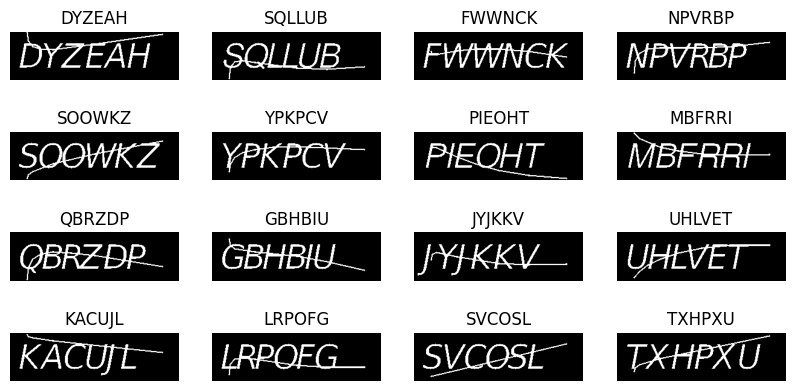

In [7]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Create the OCR Model

In [14]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred
    
def build_model():
    # Inputs
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Initial normalization
    x = layers.BatchNormalization()(input_img)
    
    # Simplified convolutional block 1
    x = layers.Conv2D(32, (3, 3), padding="same", name="Conv1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Dropout(0.2)(x)  # Add dropout
    
    # Simplified convolutional block 2
    x = layers.Conv2D(64, (3, 3), padding="same", name="Conv2")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Dropout(0.2)(x)  # Add dropout
    
    # Reshape layer
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    
    # Simplified Dense layer
    x = layers.Dense(128, name="dense1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.4)(x)  # Add dropout

    # Single-layer RNN
    x = layers.Bidirectional(
        layers.LSTM(64, return_sequences=True, dropout=0.3)
    )(x)
    
    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, 
        activation="softmax",
        name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    
    # Reduce learning rate
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    
    model.compile(optimizer=opt)
    return model

# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 280, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 280, 80, 1)  4           ['image[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 Conv1 (Conv2D)                 (None, 280, 80, 32)  320         ['batch_normalization_4[0][0]']  
                                                                                       

## Train the Neural Network

In [10]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=8,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        save_best_only=True,  # Changed to save_best_only
        save_weights_only=False,  # Ensure saving the complete model
        verbose=1
    )
]

# Add L2 regularization
regularizer = keras.regularizers.l2(1e-4)
for layer in model.layers:
    if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv2D):
        layer.kernel_regularizer = regularizer

# Train the model
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=150,
        callbacks=callbacks,
        batch_size=32
    )

# Save the complete model after training
tf.keras.models.save_model(
    model,
    'complete_model.h5',
    save_format='h5',
    include_optimizer=False  # Do not save optimizer state to reduce file size
)

Epoch 1/150
49/49 [==============================] - ETA: 0s - loss: 51.5362
Epoch 1: val_loss improved from inf to 21.78441, saving model to best_model.h5
49/49 [==============================] - 4s 73ms/step - loss: 51.5362 - val_loss: 21.7844 - lr: 5.0000e-04
Epoch 2/150
48/49 [============================>.] - ETA: 0s - loss: 21.4709
Epoch 2: val_loss did not improve from 21.78441
49/49 [==============================] - 2s 45ms/step - loss: 21.4701 - val_loss: 22.2423 - lr: 5.0000e-04
Epoch 3/150
49/49 [==============================] - ETA: 0s - loss: 21.3084
Epoch 3: val_loss did not improve from 21.78441
49/49 [==============================] - 2s 47ms/step - loss: 21.3084 - val_loss: 21.9207 - lr: 5.0000e-04
Epoch 4/150
48/49 [============================>.] - ETA: 0s - loss: 21.2582
Epoch 4: val_loss improved from 21.78441 to 21.76079, saving model to best_model.h5
49/49 [==============================] - 2s 44ms/step - loss: 21.2590 - val_loss: 21.7608 - lr: 5.0000e-04
Epoch

## Predictions with Trained Neural Network

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 280, 80, 1)]      0         
                                                                 
 batch_normalization (BatchN  (None, 280, 80, 1)       4         
 ormalization)                                                   
                                                                 
 Conv1 (Conv2D)              (None, 280, 80, 32)       320       
                                                                 
 batch_normalization_1 (Batc  (None, 280, 80, 32)      128       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 280, 80, 32)       0         
                                                                 
 pool1 (MaxPooling2D)        (None, 140, 40, 32)       0   

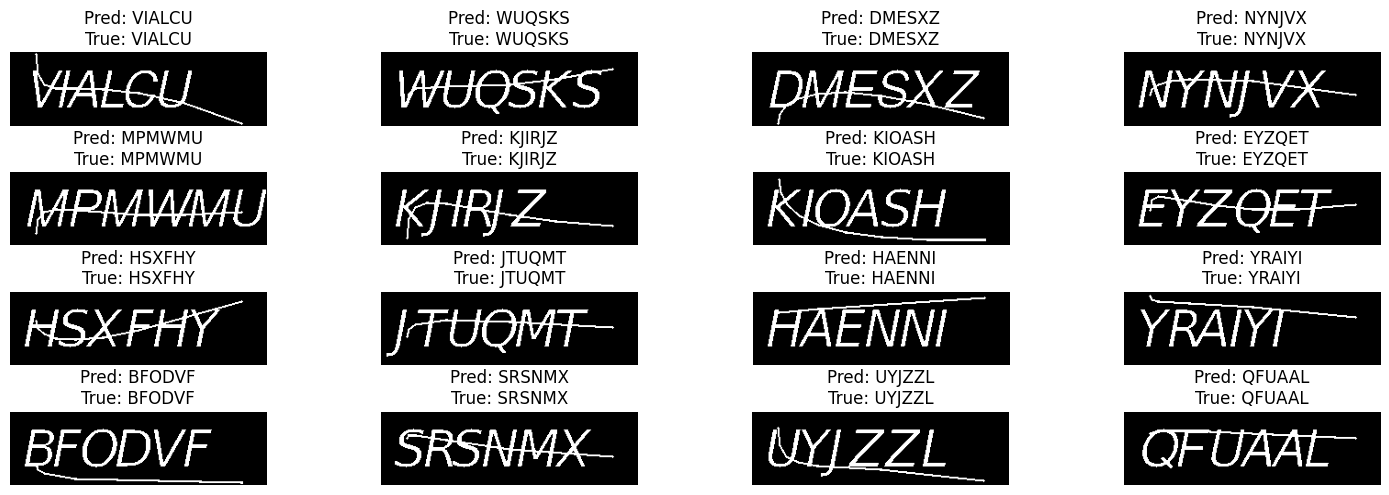

In [17]:
# Get the prediction model - use the correct layer names
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# Decode the model's prediction output
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    # Decode using greedy search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]

    # Convert results to text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Check results on the validation set
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    # Make predictions
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    # Get original labels
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    # Visualize results
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        # Display RGBA image
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Pred: {pred_texts[i]}\nTrue: {orig_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()